<a href="https://colab.research.google.com/github/ThinhPham24/Detectron2/blob/main/Orchid_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 62.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.5.0+cu101

In [ ]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 620 kB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=a55ea98e4388621a39b72e79b931e2852c5ac5a075766b5c831e9b0a212ecba0
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=3604bf70dc3e3c1975836502ab2c132fdc42fdab05c406eeb634a07c3b33969d
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/dataset_new_orchid/coco.zip"

Archive:  /content/drive/MyDrive/dataset_new_orchid/coco.zip
   creating: coco/
   creating: coco/annotations/
  inflating: coco/annotations/orchid_train.json  
  inflating: coco/annotations/orchid_val.json  
   creating: coco/train/
  inflating: coco/train/1000.jpg     
  inflating: coco/train/1001.jpg     
  inflating: coco/train/1003.jpg     
  inflating: coco/train/1005.jpg     
  inflating: coco/train/1006.jpg     
  inflating: coco/train/1007.jpg     
  inflating: coco/train/1008.jpg     
  inflating: coco/train/1009.jpg     
  inflating: coco/train/1011.jpg     
  inflating: coco/train/1013.jpg     
  inflating: coco/train/1015.jpg     
  inflating: coco/train/1016.jpg     
  inflating: coco/train/1017.jpg     
  inflating: coco/train/1018.jpg     
  inflating: coco/train/1019.jpg     
  inflating: coco/train/1020.jpg     
  inflating: coco/train/1024.jpg     
  inflating: coco/train/1025.jpg     
  inflating: coco/train/1026.jpg     
  inflating: coco/train/1027.jpg     
  infl

In [ ]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import cv2

def get_orchid_dicts(directory):
    classes = ['class_1','class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9','class_10','class_11','class_12','class_13','class_14','class_15','class_16','class_17','class_18']
    dataset_dicts = []
    
    name_json = str(directory).split('/')[-1]
    directory_img = "/content/coco/{}".format(name_json)
    direction_json = str(directory).split(name_json)[0]
    for filename in [file for file in os.listdir(direction_json) if file == 'orchid_{}.json'.format(name_json)]:
        json_file = os.path.join(direction_json, filename)
        with open(json_file) as f:
            img_anns = json.load(f)
        # imgs = img_anns["images"]
        number_img = 1
        for idx, v in enumerate(img_anns["images"]):
            record ={}
            list_ann =[]
            filename = os.path.join(directory_img,v["file_name"])
            height, width = cv2.imread(filename).shape[:2]
            record["file_name"] = filename
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width
            annotation = img_anns["annotations"]
            objs = []
            for idy, m in enumerate(img_anns["annotations"]):
              # print("imag id", m)
              if m["image_id"] == v["id"]:
                  obj = {
                  "bbox": m["bbox"],
                  "bbox_mode": BoxMode.XYWH_ABS,
                  "segmentation": m["segmentation"],
                  "category_id": classes.index(m["category_id"]),
                  "iscrowd": 0
                  }
                  objs.append(obj)
              record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts
# annotation_json = get_orchid_dicts("/content/coco/annotations/val")

In [ ]:
# Be carefull the name you named
for d in ["train", "val"]:
    DatasetCatalog.register("mydataset_" + d, lambda d=d: get_orchid_dicts("/content/coco/annotations/" + d))
    MetadataCatalog.get("mydataset_" + d).set(thing_classes=["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18"])
MetadataCatalog.get("mydatset_train").thing_classes=['class_1','class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9','class_10','class_11','class_12','class_13','class_14','class_15','class_16','class_17','class_18']
mydataset_metadata = MetadataCatalog.get("mydatset_train")

In [ ]:
import os, json, cv2, random

d value {'file_name': '/content/coco/train/1687.jpg', 'image_id': 268, 'height': 456, 'width': 640, 'annotations': [{'bbox': [154.0, 173.0, 180.0, 202.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[184.0, 374.5, 168.0, 374.5, 155.5, 362.0, 153.5, 322.0, 159.5, 295.0, 186.5, 232.0, 202.0, 215.5, 214.5, 209.0, 204.5, 195.0, 208.0, 190.5, 248.0, 191.5, 266.0, 179.5, 303.0, 172.5, 333.5, 215.0, 286.0, 247.5, 275.5, 268.0, 268.0, 275.5, 266.0, 266.5, 254.0, 269.5, 251.5, 261.0, 249.5, 293.0, 241.5, 321.0, 232.5, 338.0, 205.0, 367.5, 196.0, 373.5, 184.0, 374.5]], 'category_id': 11}, {'bbox': [249.0, 103.0, 88.0, 87.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[308.0, 189.5, 289.5, 179.0, 283.5, 160.0, 274.0, 146.5, 252.0, 137.5, 248.5, 133.0, 254.0, 123.5, 281.0, 102.5, 289.0, 120.5, 313.0, 132.5, 325.0, 133.5, 331.5, 148.0, 336.5, 152.0, 308.0, 189.5]], 'category_id': 8}, {'bbox': [364.0, 112.0, 89.0, 123.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[399.0

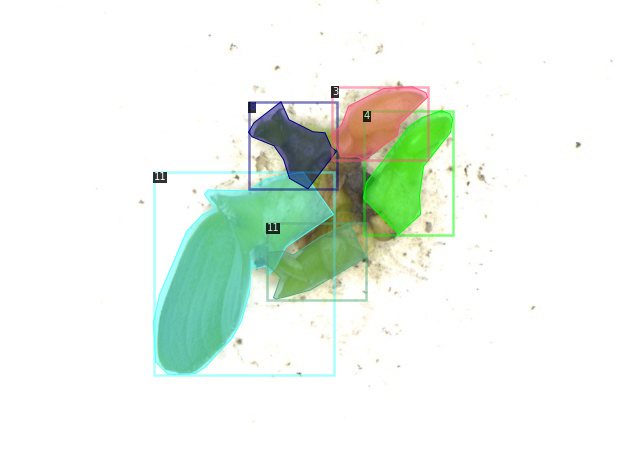

d value {'file_name': '/content/coco/train/1603.jpg', 'image_id': 103, 'height': 456, 'width': 640, 'annotations': [{'bbox': [342.0, 168.0, 150.0, 92.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[436.0, 259.5, 423.0, 258.5, 415.0, 253.5, 409.0, 244.5, 396.0, 255.5, 387.0, 252.5, 388.5, 232.0, 348.0, 212.5, 341.5, 203.0, 344.5, 188.0, 364.0, 171.5, 377.0, 167.5, 401.0, 180.5, 408.5, 195.0, 425.0, 211.5, 443.0, 215.5, 464.0, 215.5, 481.0, 209.5, 491.5, 218.0, 487.5, 233.0, 477.0, 242.5, 436.0, 259.5]], 'category_id': 17}, {'bbox': [148.0, 221.0, 194.0, 152.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[262.0, 372.5, 239.0, 369.5, 208.0, 352.5, 197.5, 340.0, 201.5, 333.0, 189.5, 312.0, 154.0, 300.5, 147.5, 293.0, 148.5, 286.0, 221.0, 287.5, 259.0, 277.5, 272.5, 271.0, 269.5, 258.0, 261.5, 256.0, 260.5, 246.0, 267.5, 232.0, 279.0, 220.5, 324.0, 225.5, 333.5, 236.0, 341.5, 253.0, 327.5, 281.0, 316.5, 295.0, 311.5, 327.0, 305.5, 342.0, 289.0, 364.5, 274.0, 371.5, 262.0

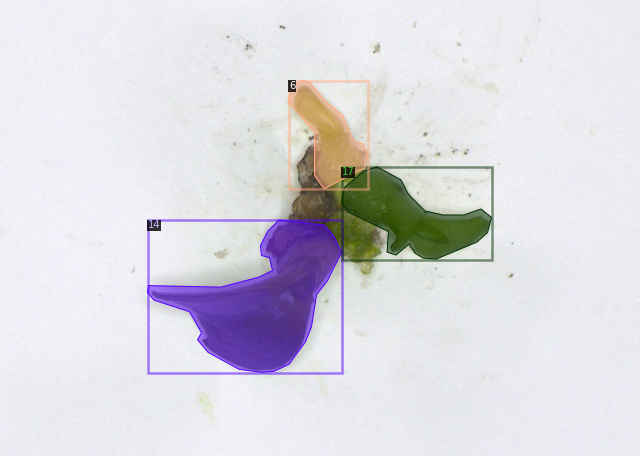

d value {'file_name': '/content/coco/train/1231.jpg', 'image_id': 132, 'height': 456, 'width': 640, 'annotations': [{'bbox': [376.0, 63.0, 101.0, 127.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[406.0, 189.5, 394.0, 187.5, 383.0, 178.5, 375.5, 161.0, 385.0, 153.5, 425.0, 149.5, 434.5, 143.0, 440.5, 130.0, 445.5, 77.0, 450.5, 66.0, 459.0, 62.5, 469.5, 81.0, 474.5, 103.0, 476.5, 119.0, 472.5, 141.0, 455.5, 165.0, 444.0, 174.5, 421.0, 188.5, 406.0, 189.5]], 'category_id': 2}, {'bbox': [183.0, 223.0, 202.0, 170.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[214.0, 392.5, 201.0, 391.5, 192.0, 385.5, 184.5, 372.0, 184.5, 334.0, 195.0, 316.5, 213.0, 304.5, 238.0, 294.5, 280.0, 284.5, 296.5, 271.0, 294.5, 255.0, 303.5, 248.0, 319.0, 226.5, 329.0, 222.5, 358.0, 230.5, 383.5, 245.0, 384.5, 255.0, 376.5, 274.0, 367.5, 276.0, 376.5, 289.0, 370.0, 295.5, 353.0, 288.5, 344.0, 278.5, 340.5, 285.0, 342.5, 300.0, 364.5, 329.0, 362.5, 340.0, 355.5, 339.0, 356.0, 352.5, 348.5, 348

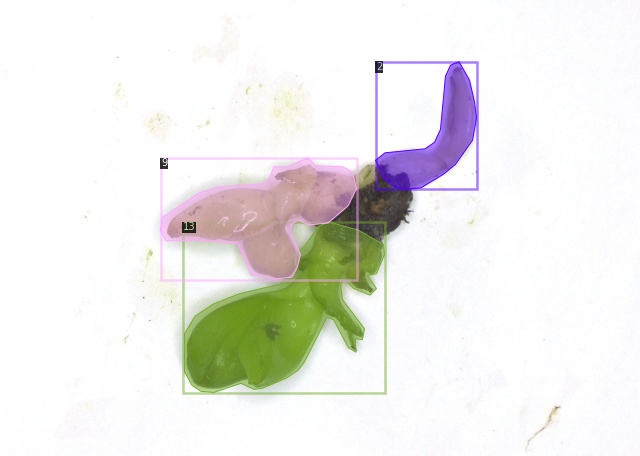

In [ ]:
dataset_dicts = get_orchid_dicts("/content/coco/annotations/train")
for d in random.sample(dataset_dicts, 3):
    print("d value",d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mydataset_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
###############################################CHANGE HERE#########################3
cfg.DATASETS.TRAIN = ("mydataset_train",)
cfg.DATASETS.TEST = ("mydataset_val",)
cfg.DATASETS.VAL = ("mydataset_val",)
################################################################################3
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000  # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 18  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS=[[0.5, 1.0, 2.0]]
cfg.MODEL.ANCHOR_GENERATOR.SIZES=[[32], [64], [128], [256], [512]]

In [ ]:
import numpy as np
import logging
from detectron2.data import build_detection_test_loader
from detectron2.data import DatasetMapper
from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime

In [ ]:
print(cfg.DATASETS.TEST)

('mydatset_val',)


In [ ]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm
# This is slow, but it is exacly.
class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        # Should be careful this parameter, if you register the above dataset name for validate, you wil change here.
        self._loader = build_detection_test_loader(self.cfg,self.cfg.DATASETS.VAL[0],DatasetMapper(self.cfg,True))

        
    def after_step(self):

        # data = next(self._loader)
        # You change change the calculating method to computer the validation loss here.
        for idx, inputs in enumerate(self._loader):
            with torch.no_grad():
                loss_dict = self.trainer.model(inputs)
                
                losses = sum(loss_dict.values())
                assert torch.isfinite(losses).all(), loss_dict

                loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                    comm.reduce_dict(loss_dict).items()}
                losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                            **loss_dict_reduced)
# This is run faster than, but it is approximate value.
class ValidationLoss_approx(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)     
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict
            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
# WAY 1 is okay, but is slow
# val_loss = ValidationLoss(cfg)  
# WAY 2
val_loss = ValidationLoss_approx(cfg)  
trainer.register_hooks([val_loss])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)
trainer.train()

[08/09 14:33:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[08/09 14:33:59 d2.engine.train_loop]: Starting training from iteration 0
[08/09 14:34:38 d2.utils.events]:  eta: 0:16:23  iter: 19  total_loss: 4.693  loss_cls: 2.928  loss_box_reg: 0.939  loss_mask: 0.695  loss_rpn_cls: 0.115  loss_rpn_loc: 0.024  total_val_loss: 4.646  val_loss_cls: 2.914  val_loss_box_reg: 0.941  val_loss_mask: 0.694  val_loss_rpn_cls: 0.065  val_loss_rpn_loc: 0.023  time: 0.9945  data_time: 0.0148  lr: 0.000005  max_mem: 6419M
[08/09 14:35:16 d2.utils.events]:  eta: 0:16:08  iter: 39  total_loss: 4.520  loss_cls: 2.719  loss_box_reg: 0.990  loss_mask: 0.694  loss_rpn_cls: 0.100  loss_rpn_loc: 0.028  total_val_loss: 4.446  val_loss_cls: 2.709  val_loss_box_reg: 0.947  val_loss_mask: 0.695  val_loss_rpn_cls: 0.071  val_loss_rpn_loc: 0.022  time: 0.9838  data_time: 0.0066  lr: 0.000010  max_mem: 6419M
[08/09 14:35:54 d2.utils.events]:  eta: 0:15:50  iter: 59  total_loss: 4.061  loss_cls: 2.330  loss_box_reg: 0.947  loss_mask: 0.694  loss_rpn_cls: 0.065  loss_rpn_loc:

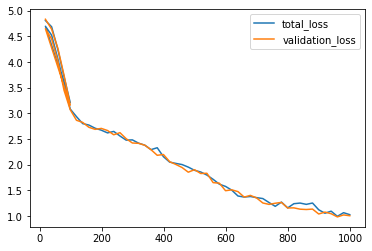

In [ ]:
import json
import matplotlib.pyplot as plt
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines
experiment_metrics = load_json_arr("/content/output/metrics.json")
plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_val_loss' in x], 
    [x['total_val_loss'] for x in experiment_metrics if 'total_val_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper right')
plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("mydataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "mydataset_val",DatasetMapper(cfg,True))
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [08/09 15:05:56 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'mydataset_val'. Trying to convert it to COCO format ...
[08/09 15:05:56 d2.data.datasets.coco]: Converting annotations of dataset 'mydataset_val' to COCO format ...)
[08/09 15:05:57 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/09 15:05:57 d2.data.datasets.coco]: Conversion finished, #images: 148, #annotations: 433
[08/09 15:05:57 d2.data.datasets.coco]: Caching COCO format annotations at './output/mydataset_val_coco_format.json' ...
[08/09 15:05:57 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/09 15:05:57 d2.data.common]: Serializing 148 elements to byte tensors and concatenating them all ...
[08/09 15:05:57 d2.data.common]: Serialized dataset takes 0.25 MiB
[08/09 15:05:57 d2.evaluation.evaluator]: Start inference on 148 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
print(cfg.MODEL.WEIGHTS)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


./output/model_final.pth


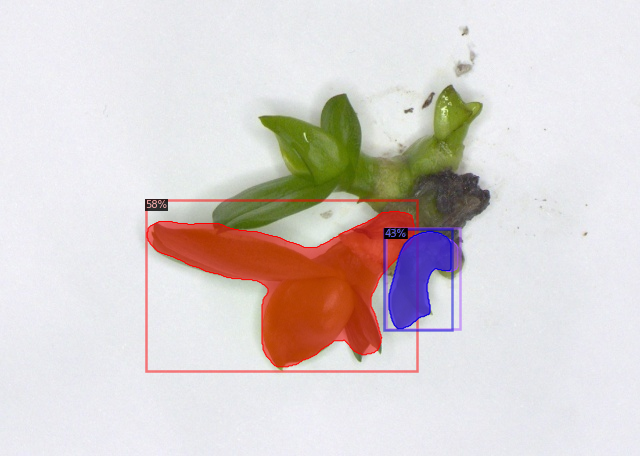

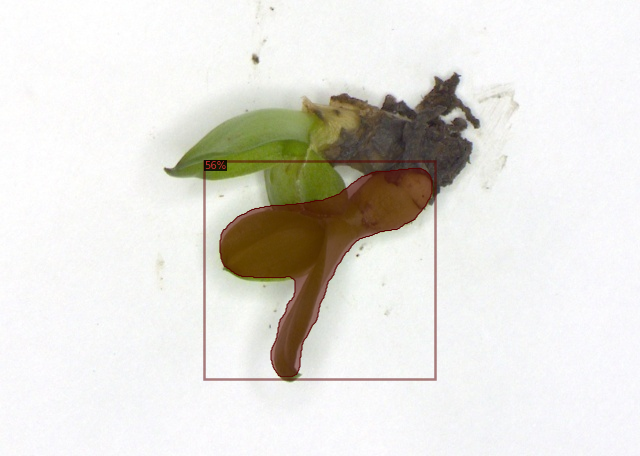

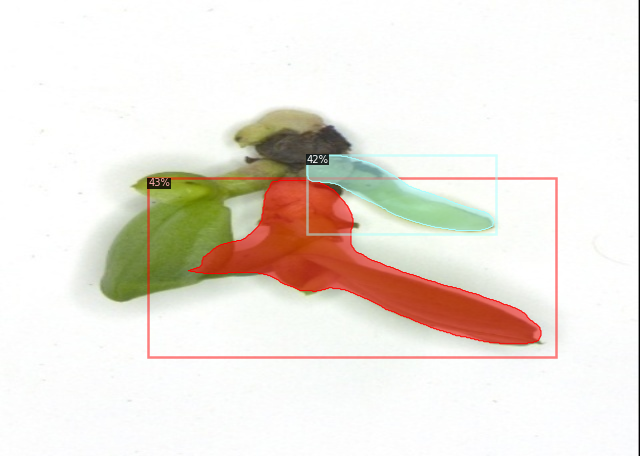

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_orchid_dicts("/content/coco/annotations/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=mydataset_metadata, 
                   scale=1,
                  #  instance_mode=ColorMode.IMAGE_BW
                    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])